# Royal University of Phnom Penh
# Faculty of Engineering

# Assignment : News Classification based on Their Headlines

### Professors: Chanpiseth Chap

### Group 3: 
- Muny Roth
- Veong Chamroeun
- Chhoun Seangly
- Seng Vutthea
- Mon David

# 1. Collect data

To acquire crucial data for our project, we will employ web scraping techniques using Selenium to extract information from the CNN website. Our objective is to retrieve key details such as the title, URL, publisher, category, and hostname of news articles. Subsequently, we will organize and store this data in a CSV (Comma-Separated Values) file. The CSV file will serve as a valuable resource for training our model.

We anticipate collecting around 10,000 articles from the news section of the CNN website. This extensive dataset will provide a diverse and comprehensive foundation for our model training.

Below is the code snippet that encapsulates the web scraping process:

In [ ]:
import csv
import uuid

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait

# CSV file path
csv_file_path = 'dataset-1.csv'

# Define CSV fieldnames
fieldnames = ["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "HOSTNAME"]

# Set up the web driver
driver = webdriver.Chrome()

# Navigate to the CNN website
driver.get("https://www.nbcnews.com/archive/articles/2022/january")

# Assuming the titles are in h3 tags, adjust this according to the actual HTML structure
main_tag = driver.find_element(By.CLASS_NAME, 'MonthPage')
title_tags = main_tag.find_elements(By.TAG_NAME, 'a')

# Append data to the CSV file
with open(csv_file_path, 'a', newline='') as file:
    titles = []
    for title in title_tags:
        # Generate unique_id
        unique_id = str(uuid.uuid4())
        title_info = {"ID": unique_id, "TITLE": title.text, "URL": title.get_attribute('href')}
        titles.append(title_info)

    writer = csv.DictWriter(file, fieldnames=fieldnames)
    if file.tell() == 0:
        writer.writeheader()

    # Loop through title tags
    for title_info in titles:
        try:
            # Open the URL of each title to extract additional information
            driver.get(title_info.get('url'))

            # Set an implicit wait to wait for elements to be present
            driver.implicitly_wait(10)

            category_tag = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, 'span[data-testid="unibrow-text"]'))
            )

            publisher_tag = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, 'div[data-activity-map="inline-byline-article-top"]'))
            )

            # Extract additional information and store it in the title_info dictionary
            title_info['PUBLISHER'] = publisher_tag.text[3:]
            title_info['CATEGORY'] = category_tag.text
            title_info['HOSTNAME'] = 'nbcnews.com'
            print(title_info)

            # Write the data rows
            writer.writerow(title_info)

        except Exception as e:
            print(f"An error occurred: {e}")
            continue

print(f"Data has been appended to {csv_file_path}.")

# Close the web driver
driver.quit()

# 2. Data Preprocessing

In this step, we will perform data preprocessing to prepare the dataset for classification. The preprocessing steps include data integration, data selection, data cleaning, and data transformation.

In [1]:
# Import libraries
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore", category=UserWarning, module="urllib3")

## 2.1 Data Integration

The data collected from the CNN website is stored in 13 separate CSV files. We will concatenate these files into a single CSV file for further processing. The concatenated CSV file will be used to train the classifiers.

In [2]:
# Read the CSV files
df1 = pd.read_csv('dataset-1.csv')
df2 = pd.read_csv('dataset-2.csv')
df3 = pd.read_csv('dataset-3.csv')
df4 = pd.read_csv('dataset-4.csv')
df5 = pd.read_csv('dataset-5.csv')
df6 = pd.read_csv('dataset-6.csv')
df7 = pd.read_csv('dataset-7.csv')
df8 = pd.read_csv('dataset-8.csv')
df9 = pd.read_csv('dataset-9.csv')
df10 = pd.read_csv('dataset-10.csv')
df11 = pd.read_csv('dataset-11.csv')
df12 = pd.read_csv('dataset-12.csv')
df13 = pd.read_csv('dataset-13.csv')

# Concatenate the DataFrames vertically (along the rows)
concatenated_df = pd.concat([
    df1,
    df2,
    df3,
    df4,
    df5,
    df6,
    df7,
    df8,
    df9,
    df10,
    df11,
    df12,
    df13
], ignore_index=True)

# Save the concatenated DataFrame to a new CSV file
concatenated_df.to_csv('dataset.csv', index=False)

print("Data has been concatenated and saved to dataset.csv.")

Data has been concatenated and saved to dataset.csv.


The concatenated CSV file is read into a Pandas DataFrame for further processing.

In [3]:
src_file = 'dataset.csv'
dataframe = pd.read_csv(src_file, encoding="utf8", quotechar="\"", engine='python', usecols=["TITLE", "CATEGORY"])

In [4]:
dataframe.head(5)

,TITLE,CATEGORY
0,Loved ones hoping for justice in the 2014 Ohio...,COLD CASE SPOTLIGHT
1,"Judges' safety is 'essential' to court system,...",U.S. NEWS
2,Suspect in Idaho killings had made 'creepy' co...,U.S. NEWS
3,Airline worker killed in accident at Alabama a...,U.S. NEWS
4,Storm dumps heavy rain and snow across California,U.S. NEWS


In [5]:
dataframe.describe()

,TITLE,CATEGORY
count,11936,11795
unique,11823,215
top,Graphic: Track grocery price trends,U.S. NEWS
freq,6,2692


In [6]:
dataframe.shape

(11936, 2)

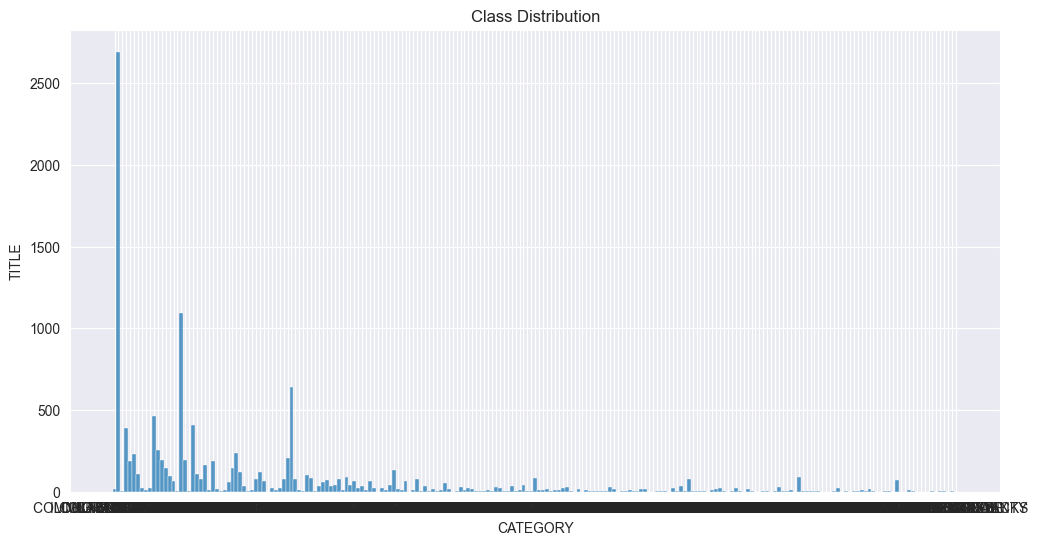

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(dataframe['CATEGORY'])
plt.title("Class Distribution")
plt.ylabel('TITLE')
plt.show()

## 2.2 Data Selection

The dataset consists of 11,936 rows and 2 columns. The "TITLE" column encompasses news headlines, while the "CATEGORY" column delineates the respective news categories. Given the abundance of categories, a filtering process will be applied to exclude those with fewer than 300 rows, streamlining the dataset for further analysis.

In [8]:
dataframe = dataframe.groupby("CATEGORY").filter(lambda x: len(x) >= 300)

## 2.3 Data Cleaning

The dataset undergoes a thorough cleaning process to handle missing data and eliminate duplicate rows. The cleaning process ensures the dataset is free from inconsistencies that might affect the performance of the classifiers.

In [9]:
# Checking for missing data
if any(dataframe.isnull().any()):
    print('Missing Data\n')
    print(dataframe.isnull().sum())
else:
    print('No missing data')

No missing data


In [10]:
# Checking for duplicate rows
if any(dataframe.duplicated()):
    print('Duplicate rows found')
    print('Number of duplicate rows= ', dataframe[dataframe.duplicated()].shape[0])
    dataframe.drop_duplicates(inplace=True, keep='first')
    dataframe.reset_index(inplace=True, drop=True)
    print('Dropping duplicates\n')
else:
    print('No duplicate data')

Duplicate rows found
Number of duplicate rows=  35
Dropping duplicates


As a result of the selection and the cleaning process, the dataset is reduced.

In [11]:
dataframe.shape

(5653, 2)

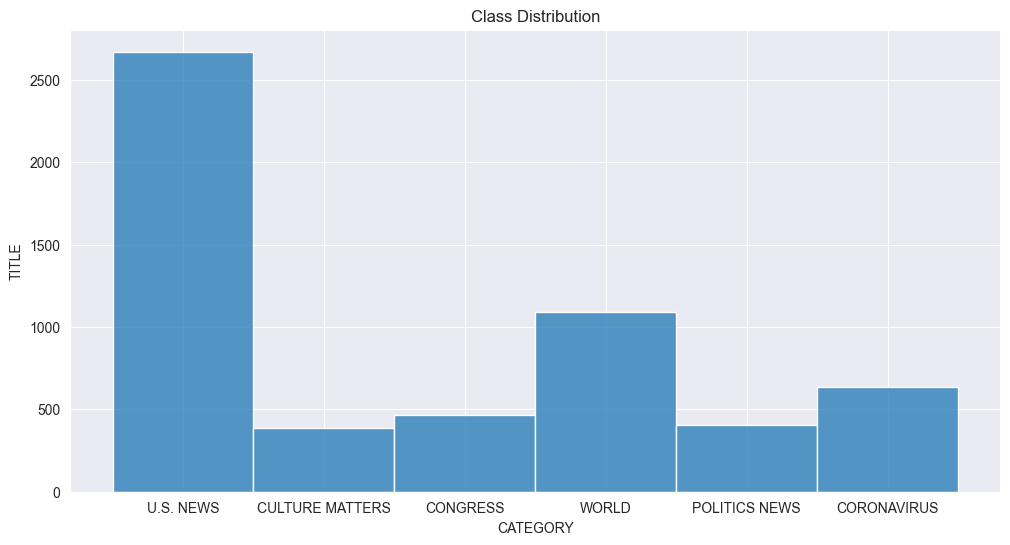

In [12]:
# Explore class distribution
plt.figure(figsize=(12, 6))
sns.histplot(dataframe['CATEGORY'])
plt.title("Class Distribution")
plt.ylabel('TITLE')
plt.show()

## 2.4 Text Preprocessing and Data Transformation

Text preprocessing is a critical step in preparing the data for classification. The following steps are performed:

- Tokenization and lemmatization to convert text into a structured format.
- Removal of numerical values, special characters, punctuation, and stop words.
- Transformation of text data using Term Frequency-Inverse Document Frequency (TF-IDF) vectorization.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn import set_config

# Set sklearn config to output Pandas DataFrame
set_config(transform_output="pandas")
wnl = WordNetLemmatizer()


# Function for cleaning and tokenize the headline
def tokenize(doc):
    document = doc.lower()  # convert the content of the headline to lowercase
    document = re.sub(r'\d+', '', document)  # remove all the digits inside the content (using regular expressions)
    document = re.sub(r'[^a-zA-Z\s]', '',
                      document)  # remove all the special characters inside the content (using regular expressions)
    document = document.translate(str.maketrans('', '', string.punctuation))  # remove the punctuations (, . ! # ...)
    document = document.strip()  # remove the spaces at the start and end of the headline
    return [wnl.lemmatize(token) for token in word_tokenize(document) if token not in stopwords.words('english')]
    # tokenize the headlines
    # and then filter only the words that are not in the english stopwords (words that are commonly used and give no benefits to the classifier)
    # and finally templatize all the tokens


# Preprocessing Pipeline
preprocessor = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize, token_pattern=None)),
])

# Transforming the dataset using TF-IDF
tfidf_dataset = preprocessor.fit_transform(dataframe["TITLE"].values)

# 3. Training Model

## 3.1 Label encoder

The target labels are encoded using the LabelEncoder class from the scikit-learn library. The encoded labels are used to train the classifiers.

In [14]:
from sklearn.preprocessing import LabelEncoder

# Encode the target labels
le = LabelEncoder()
class_label = le.fit_transform(dataframe["CATEGORY"])

## 3.2 Train-Test Split

The dataset is split into training and testing datasets. The training dataset is used to train the classifiers, while the testing dataset is used to evaluate the performance of the classifiers.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_dataset.toarray(),  # Convert TF-IDF sparse matrix to dense array
    class_label,  # Target labels
    test_size=0.3  # the size of the testing dataset (in percentage between 0 and 1)
)

print(X_train.shape)
print(X_test.shape)

(3957, 9149)
(1696, 9149)


## 3.3 Model Training

### 3.3.1 Decision Tree Classifier

A Decision Tree classifier is built using the scikit-learn library and trained on the preprocessed data, utilizing the TF-IDF transformed features with the Gini impurity criterion for node splitting.

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree classifier
dt_model = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=42)

# Train the classifier on the training dataset
dt_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = dt_model.predict(X_test)

### 3.3.2 Naive Bayes Classifier

A Multinomial Naive Bayes classifier is built using the scikit-learn library and trained on the preprocessed data, utilizing the TF-IDF transformed features for text classification.

In [17]:
from sklearn.naive_bayes import MultinomialNB

# Create a Multinomial Naive Bayes classifier
nb_model = MultinomialNB()

# Train the classifier on the training dataset
nb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_nb = nb_model.predict(X_test)

### 3.3.3 Neural Network Classifier

A Neural Network model with an input layer, hidden layers, and an output layer is built using TensorFlow and Keras. The model is trained on the TF-IDF features using the Adam optimizer and sparse categorical cross-entropy loss.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Build the neural network model
nn_model = Sequential()
# Input layer
nn_model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
# Hidden layers
nn_model.add(Dense(32, activation='relu'))
# Output layer
num_classes = len(np.unique(class_label))
nn_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
nn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
nn_model_trained = nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Make predictions on the test data
y_pred_nn = np.argmax(nn_model.predict(X_test), axis=-1)

/Users/munyroth/Desktop/Python/Assignment/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/20
112/112 [==============================] - 0s 2ms/step - loss: 1.5800 - accuracy: 0.4681 - val_loss: 1.3673 - val_accuracy: 0.4747
Epoch 2/20
112/112 [==============================] - 0s 1ms/step - loss: 1.1630 - accuracy: 0.5378 - val_loss: 1.0975 - val_accuracy: 0.6389
Epoch 3/20
112/112 [==============================] - 0s 1ms/step - loss: 0.7440 - accuracy: 0.7846 - val_loss: 0.8674 - val_accuracy: 0.7045
Epoch 4/20
112/112 [==============================] - 0s 1ms/step - loss: 0.4315 - accuracy: 0.8635 - val_loss: 0.7597 - val_accuracy: 0.7172
Epoch 5/20
112/112 [==============================] - 0s 1ms/step - loss: 0.2716 - accuracy: 0.9270 - val_loss: 0.7182 - val_accuracy: 0.7424
Epoch 6/20
112/112 [==============================] - 0s 1ms/step - loss: 0.1777 - accuracy: 0.9832 - val_loss: 0.7104 - val_accuracy: 0.7399
Epoch 7/20
112/112 [==============================] - 0s 1ms/step - loss: 0.1126 - accuracy: 0.9930 - val_loss: 0.7104 - val_accuracy: 0.7424
Epoch 

# 4. Model Evaluation

The performance of each classifier is evaluated using metrics such as accuracy, precision, recall, and confusion matrix. The evaluation provides insights into the effectiveness of each model in classifying text data.

In [19]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns


def evaluate_model(model, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=1)

    print(f"Accuracy score of {model}: {accuracy}")
    print(f"Precision score of {model}: {precision}")
    print(f"Recall score of {model}: {recall}")
    

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

## 4.1 Decision Tree

In [20]:
evaluate_model("Decision Tree", y_test, y_pred_dt)

Accuracy score of Decision Tree: 0.7087264150943396
Precision score of Decision Tree: 0.6986764358775476
Recall score of Decision Tree: 0.7087264150943396


In [21]:
print(classification_report(y_test, y_pred_dt, zero_division=1))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       152
           1       0.78      0.81      0.79       185
           2       0.48      0.31      0.38       120
           3       0.39      0.34      0.36       111
           4       0.75      0.82      0.78       792
           5       0.73      0.68      0.70       336

    accuracy                           0.71      1696
   macro avg       0.63      0.60      0.61      1696
weighted avg       0.70      0.71      0.70      1696


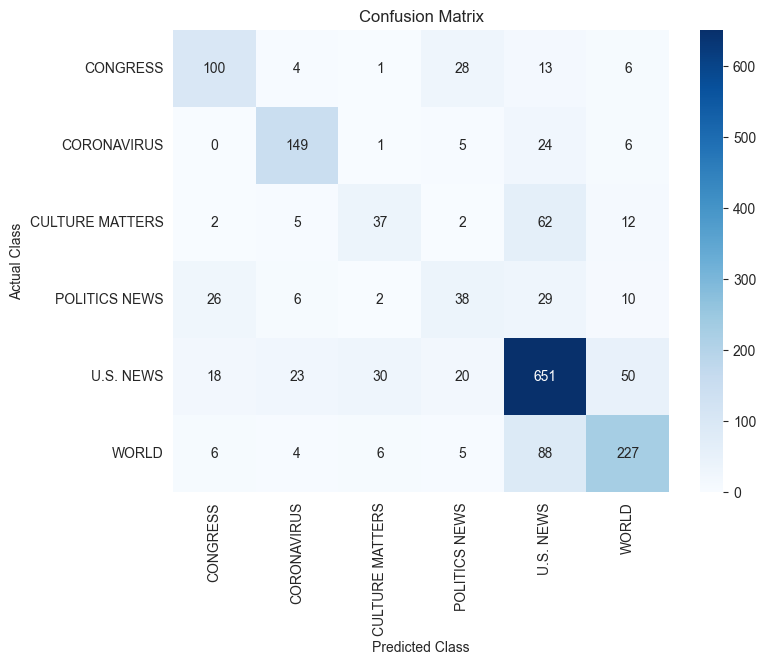

In [22]:
plot_confusion_matrix(y_test, y_pred_dt, classes=le.classes_)

## 4.2 Naive Bayes

In [23]:
evaluate_model("Naive Bayes", y_test, y_pred_nb)

Accuracy score of Naive Bayes: 0.6373820754716981
Precision score of Naive Bayes: 0.7535728824602057
Recall score of Naive Bayes: 0.6373820754716981


In [24]:
print(classification_report(y_test, y_pred_nb, zero_division=1))

              precision    recall  f1-score   support

           0       0.93      0.43      0.59       152
           1       0.84      0.35      0.50       185
           2       1.00      0.00      0.00       120
           3       1.00      0.00      0.00       111
           4       0.58      0.99      0.73       792
           5       0.87      0.49      0.63       336

    accuracy                           0.64      1696
   macro avg       0.87      0.38      0.41      1696
weighted avg       0.75      0.64      0.57      1696


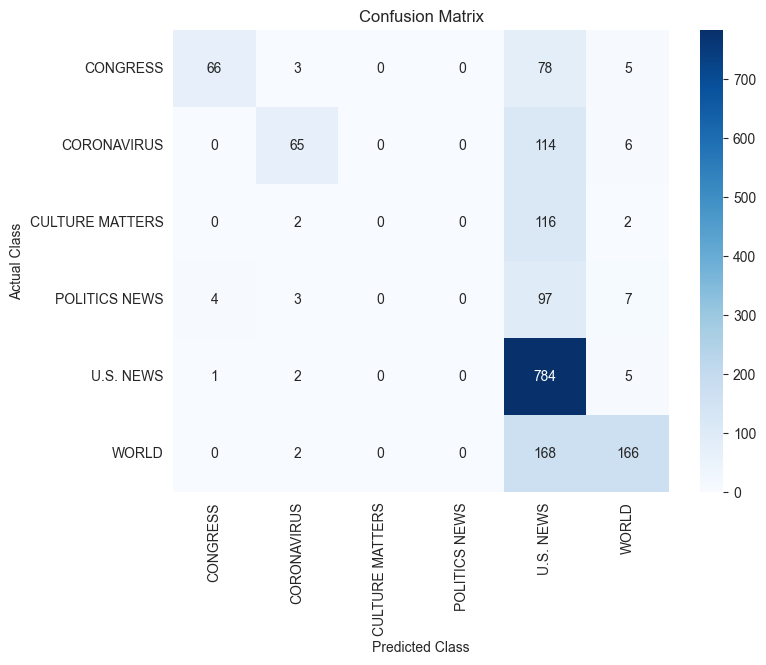

In [25]:
plot_confusion_matrix(y_test, y_pred_nb, classes=le.classes_)

## 4.3 Neural Network

In [26]:
evaluate_model("Neural Network", y_test, y_pred_nn)

Accuracy score of Neural Network: 0.7617924528301887
Precision score of Neural Network: 0.756762100563538
Recall score of Neural Network: 0.7617924528301887


In [27]:
print(classification_report(y_test, y_pred_nn, zero_division=1))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       152
           1       0.80      0.74      0.77       185
           2       0.57      0.42      0.49       120
           3       0.47      0.44      0.45       111
           4       0.79      0.89      0.84       792
           5       0.80      0.74      0.77       336

    accuracy                           0.76      1696
   macro avg       0.70      0.65      0.67      1696
weighted avg       0.76      0.76      0.76      1696


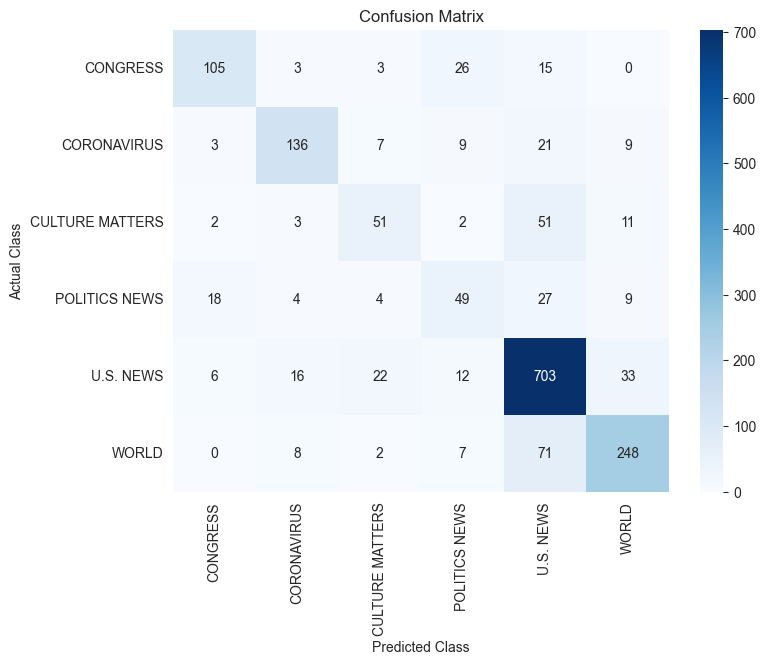

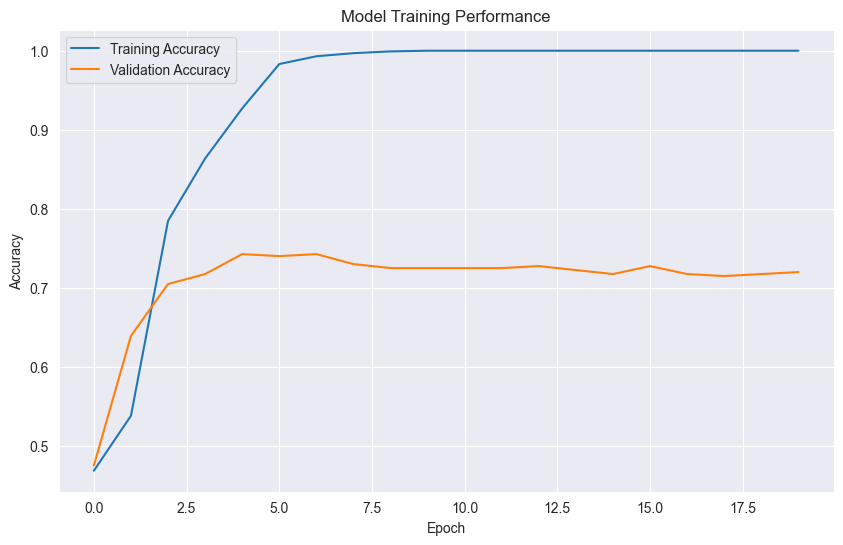

In [28]:
def plot_learning_curve(history):
    plt.figure(figsize=(10, 6))

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Training Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


plot_confusion_matrix(y_test, y_pred_nn, classes=le.classes_)
plot_learning_curve(nn_model_trained)

# 5. Conclusion

Conclusively, the Neural Network classifier outperforms the other classifiers in terms of accuracy, precision, and recall. The Decision Tree classifier achieves an accuracy of 0.71, a precision of 0.70, and a recall of 0.71. The Naive Bayes classifier achieves an accuracy of 0.64, a precision of 0.75, and a recall of 0.64. The Neural Network classifier achieves an accuracy of 0.76, a precision of 0.76, and a recall of 0.76.